In [1]:
import matplotlib.pylab as plt
import pandas as pd
import os

%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data/")

ORDERS = os.path.join(DATA_DIR, "orders.csv")
REVIEWS = os.path.join(DATA_DIR, "reviews.csv")
SIZE_MAPPINGS = os.path.join(DATA_DIR, "size_mapping.csv")
STYLE_ATTR = os.path.join(DATA_DIR, "style_attributes.csv")
USER_ATTR = os.path.join(DATA_DIR, "user_attributes.csv")

DATE_FRMT = "%Y-%m-%d"

#Read in data
orders = pd.read_csv(ORDERS)
reviews = pd.read_csv(REVIEWS)
size_mappings = pd.read_csv(SIZE_MAPPINGS)
style_attr = pd.read_csv(STYLE_ATTR)
user_attr = pd.read_csv(USER_ATTR)


In [3]:
def to_dates(df, cols):
    _df = df.copy()
    for col in cols:
        _df[col] = pd.to_datetime(df[col], format=DATE_FRMT)
    return _df

# Orders

 - 1231230 total records, only 1228395 are unique order_ids (~3000 duplicates)
 - 35000 unique user_ids (top has ~ 300 orders)
 - ordered_date between 2017-01-01 and 2018-03-31
 - rental begins between 2017-01-04 and 2018-07-14 (about 1.5 years of data)
 - 4000 unique styles, top 1551
 - 24167 unique skus top 556
 - no missing values
 
 # Questions
 - Why duplicate order_ids?  Are they full-row duplicates (Yes)
 - distribution of user order frequency, how many repeat interactions
 - Last date for ordered_date id 2018-03-31, last date for rental begins is 2018-07-14 (does this imply 3.5 month lag?)
 - does days_rented correlate to satisfaction / fit


In [4]:
orders = to_dates(orders, ['ordered_date', 'rental_begin_date'])
orders.drop_duplicates(inplace=True)
orders.describe(include='all')


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
count,1228395,1228395,1228395,1228395,1228395,1228395,1.228395e+06
unique,1228395,35000,433,378,4000,24167,NaN
top,492398c1-6a22-3d7e-ac7c-4b0fb7554aaa,a44957e3-180b-3fe0-a2e6-ef83b2cc17c5,2017-10-17 00:00:00,2017-12-20 00:00:00,SAL28,KS95_ONESIZE,NaN
freq,1,307,9436,12296,1549,556,NaN
first,NaN,NaN,2017-01-01 00:00:00,2017-01-04 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-03-31 00:00:00,2018-07-14 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.242047e+01
std,NaN,NaN,NaN,NaN,NaN,NaN,2.997819e+01
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00


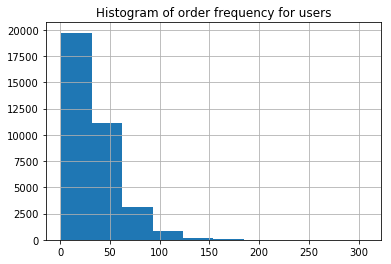

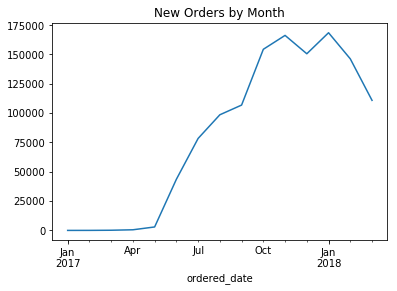

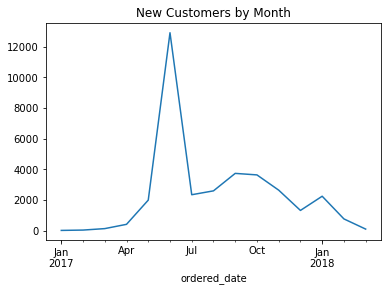

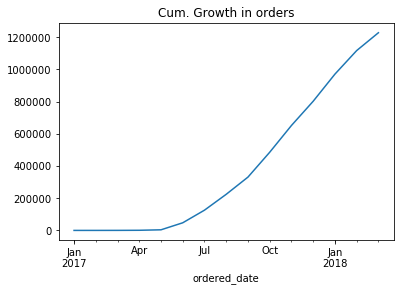

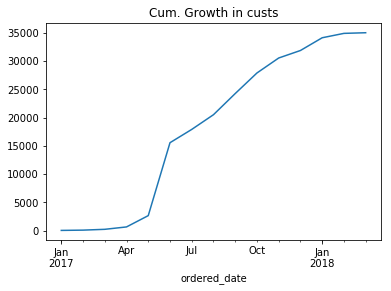

In [17]:
def make_orders_plots(df):
    _df = df.copy()
    
    plt.figure()
    ax = plt.gca()
    _df[['user_id']].apply(pd.value_counts).hist(ax=ax)
    ax.set_title("Histogram of order frequency for users")

    
    _df = _df.set_index("ordered_date").sort_index()
    _df['order_cnt'] = 1
    _df['cust_cnt'] = ~_df['user_id'].duplicated()
    _df['order_cum'] = _df['order_cnt'].cumsum()
    _df['cust_cum'] = _df['cust_cnt'].cumsum()
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Orders by Month")

    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Customers by Month")
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in orders")
    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in custs")

make_orders_plots(orders)

In [18]:
from pandas.api.types import CategoricalDtype
reviews.drop_duplicates(inplace=True)
reviews['did_you_wear_it'] = reviews['did_you_wear_it'].astype('category')

like_it_cat_type = CategoricalDtype(categories=['just_okay', 'liked_it', 'loved_it'], ordered=True)
reviews['how_did_you_like_it'] = reviews['how_did_you_like_it'].astype(like_it_cat_type)

reviews['didnt_fit'] = reviews['didnt_fit'].astype('category')
reviews['size_overall'] = reviews['size_overall'].astype('category')
reviews['size_chest'] = reviews['size_chest'].astype('category')
reviews['size_waist'] = reviews['size_waist'].astype('category')
reviews['size_waist.1'] = reviews['size_waist.1'].astype('category')
reviews['length'] = reviews['length'].astype('category')
reviews['not_flattering'] = reviews['not_flattering'].astype('category')
reviews['not_my_style'] = reviews['not_my_style'].astype('category')
reviews['other_issue'] = reviews['other_issue'].astype('category')

In [19]:
#reviews = to_dates(reviews, ['reviewed_date'])
reviews.head(10)
#reviews.size_overall.value_counts()

,order_id,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
0,9f965f2a-b0e3-3d26-87b7-127d9d4a2e50,2017-09-14,0,just_okay,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,1
1,d56facba-011a-3428-95e8-94c0805d1b28,2018-03-28,0,just_okay,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,1
2,9b5e7364-b5bf-32f7-85a3-6763981d5e4a,2017-07-11,0,just_okay,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,1,0
3,eab2dd20-4392-3ecd-9a0c-182c828846d3,2017-08-01,1,loved_it,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
4,159ad641-460c-365a-be48-fa45e8ca1b5b,2017-08-16,0,just_okay,1,too_small,just_right,just_right,just_right,just_right,just_right,0,0,0
5,d31e9cb3-6f5b-3195-91a8-3c3d8a7de67a,2017-08-15,1,liked_it,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
6,ddf0eda4-758c-3ff9-b82c-67092d29b8b4,2017-08-25,0,just_okay,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
7,9171cb26-8d2e-3312-9e3e-c4a0f41efc9c,2017-09-28,0,just_okay,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,1
8,ee2e2724-729f-3163-a39b-4895a3a8e659,2017-11-06,0,just_okay,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
9,aa373c81-aa7f-3825-9e08-352e198fb12d,2017-08-23,0,just_okay,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,1,0,0


In [ ]:
orders.head(10)    

In [ ]:
size_mappings.head(10)
#user_attr.head(10)

In [ ]:
style_attr.head(10)

In [ ]:
orders.